In [24]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
import models
from tqdm import tqdm
import torch
from PIL import Image
from torchvision.transforms import transforms
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
import pandas as pd

C:\Users\zsomb\AppData\Local\Temp\ipykernel_8424\4059286832.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In this notebook I test the model which was trained on the data with different splits then originally -> train - val - test set. The test set was completely excluded from the training -> the list of the test images is saved in test_set.txt. This test_set.txt is then read in this notebook. The model was trained for 25 epochs

In [2]:
# Specify the path to your text file containing image names
file_path = "../test_data/test_set.txt"

# Read image names from the file
with open(file_path, 'r') as file:
    test_images = [line.strip() for line in file]

In [3]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

device = 'cpu'

# load the trained model
model = models.CNN().to(device).eval()
model.load_state_dict(torch.load('../outputs/model_diff_split.pth', map_location=torch.device('cpu')))

# define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [22]:
def calc_ssim_rgb(im1, im2):
    first_ssim = ssim(im1[:,:,0], im2[:,:,0], data_range=im1[:,:,0].max() - im1[:,:,0].min())
    second_ssim = ssim(im1[:,:,1], im2[:,:,1], data_range=im1[:,:,1].max() - im1[:,:,1].min())
    third_ssim = ssim(im1[:,:,2], im2[:,:,2], data_range=im1[:,:,2].max() - im1[:,:,2].min())
    return (first_ssim + second_ssim + third_ssim) / 3

def PSNR(original, predicted):
    mse = np.mean((original - predicted) ** 2)
    if mse == 0:
        return 100
    max_pixel = original.shape[0]*original.shape[1]
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [10]:
iterations = 0

for name in test_images:
    if iterations >= 9:
        break
    image = cv2.imread(f"../input/gaussian_blurred/{name}")
    orig_image = image.copy()
    orig_image = cv2.resize(orig_image, (224, 224))
    #cv2.imwrite(f"../outputs/test_deblurred_images/blurred_{name}", orig_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = transform(image).unsqueeze(0)
    print(image.shape)

    with torch.no_grad():
        outputs = model(image)
        save_decoded_image(outputs.cpu().data, name=f"../outputs/test_deblurred_images/deblurred_{name}")


    iterations += 1
    #print(image.shape)



torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


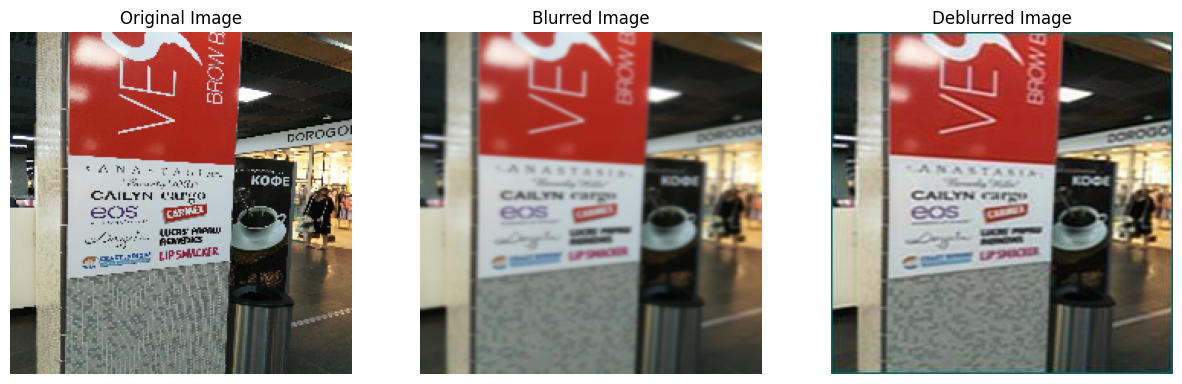

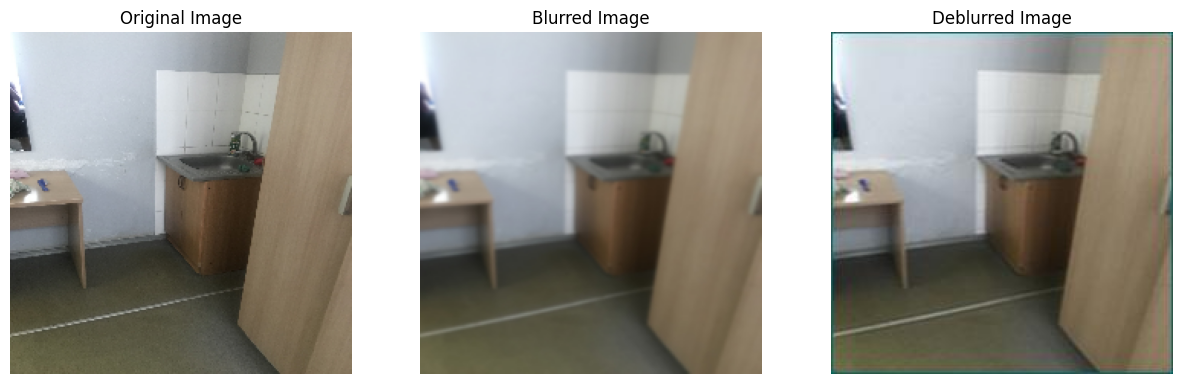

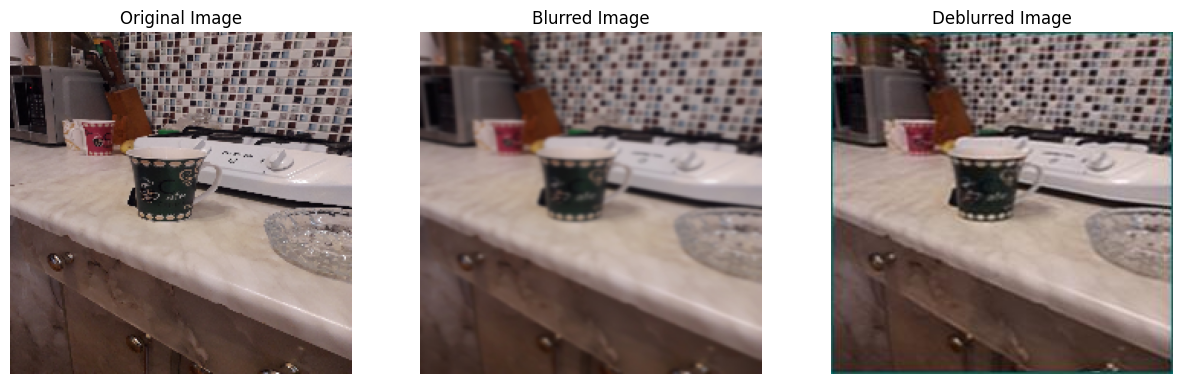

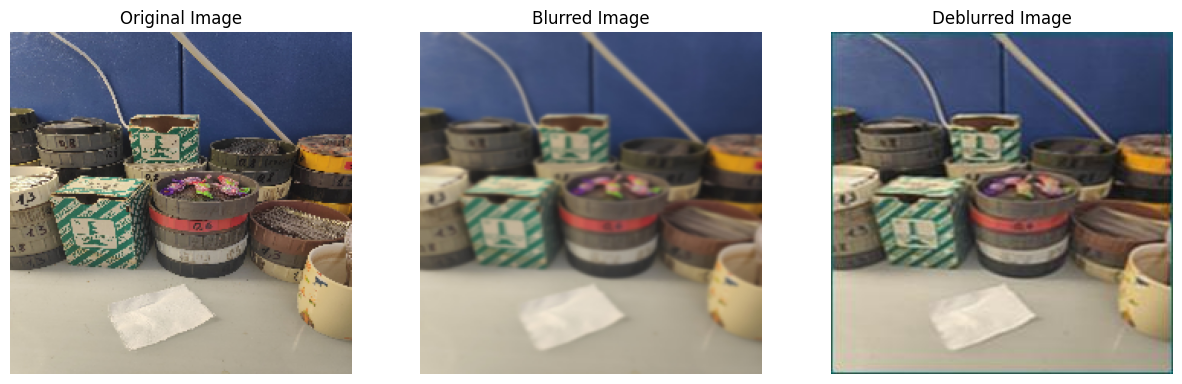

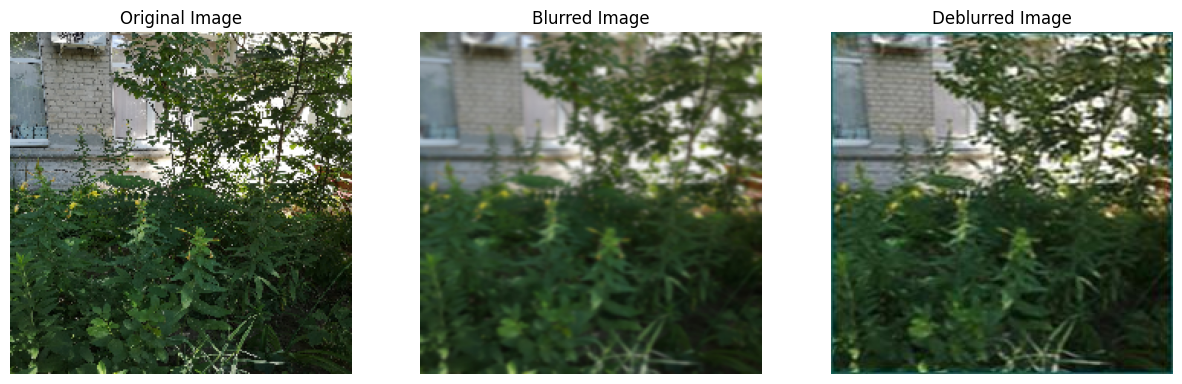

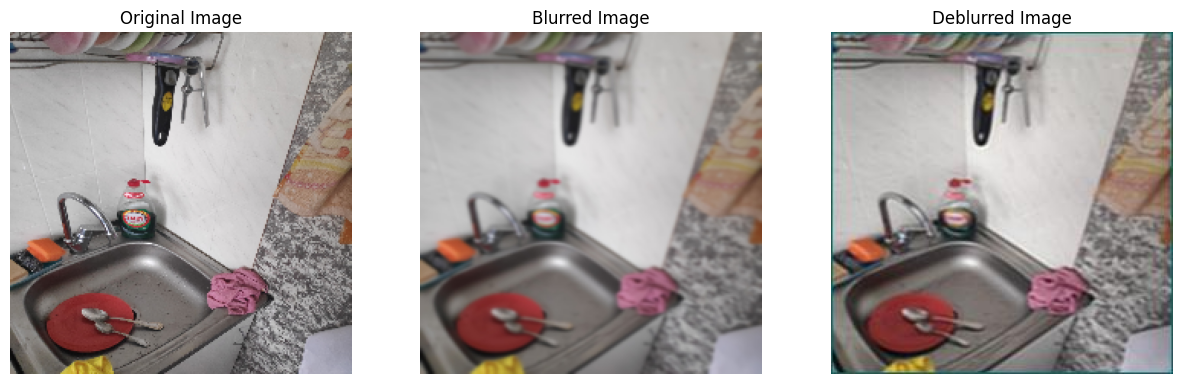

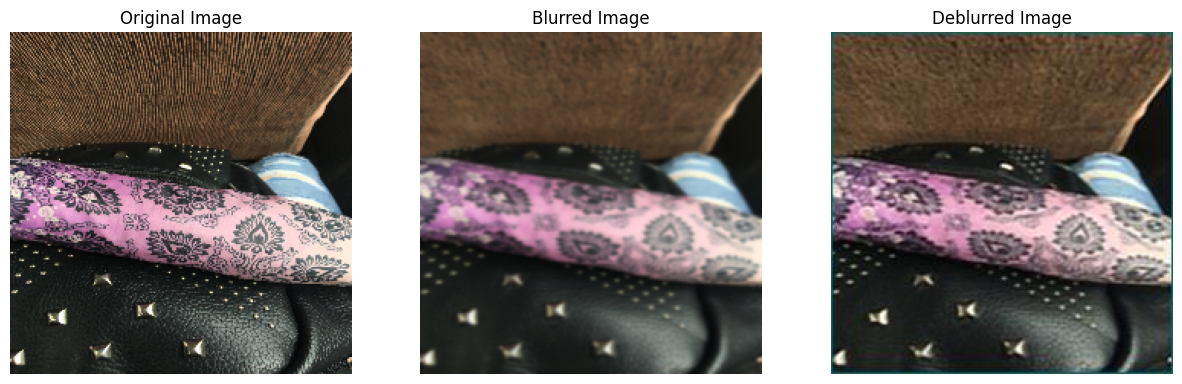

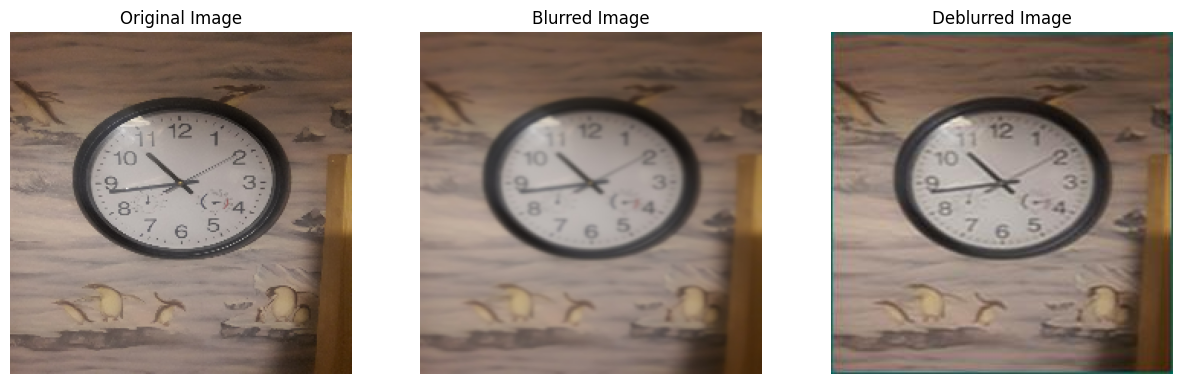

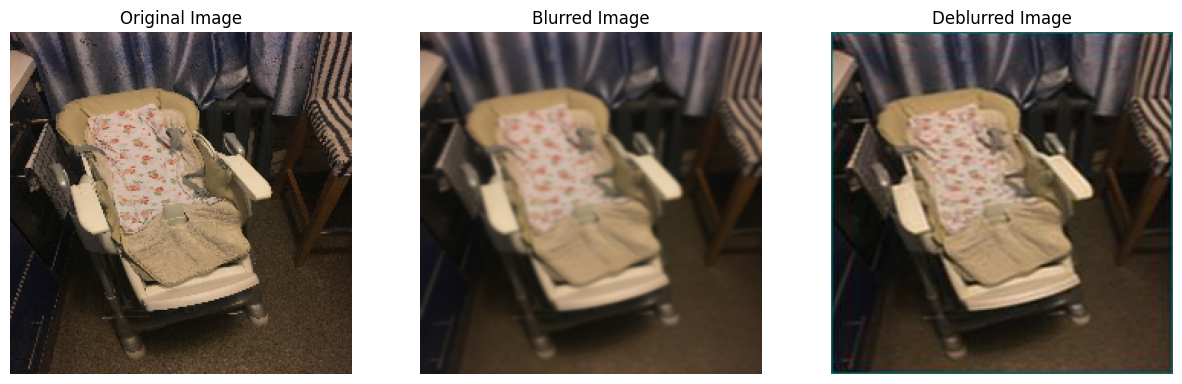

                           Image  SSIM btw Original and Blur  \
0             241_HONOR-7X_S.jpg                    0.686958   
1             92_IPHONE-7_S.jpeg                    0.911487   
2     69_SAMSUNG-GALAXY-J3_S.jpg                    0.822991   
3  310_XIAOMI-PROCOFONE-F1_S.jpg                    0.780981   
4            23_HUAWEI-P20_S.jpg                    0.537527   
5  347_XIAOMI-PROCOFONE-F1_S.jpg                    0.800302   
6             59_IPHONE-6S_S.jpg                    0.508693   
7    304_SAMSUNG-GALAXY-J7_S.jpg                    0.881697   
8            35_IPHONE-6S_S.jpeg                    0.748325   

   SSIM btw Original and Deblurred  SSIM btw Blur and Deblurred  
0                         0.700601                     0.868732  
1                         0.865917                     0.919240  
2                         0.832613                     0.894786  
3                         0.758799                     0.861908  
4                         0.5

In [29]:
iterations = 0

ssim_df = pd.DataFrame()
psnr_df = pd.DataFrame()

for file in test_images:
    if iterations >= 9:
        break

    # Read images
    orig_image = plt.imread(f"../input/sharp/{file}")
    blur_image = plt.imread(f"../input/gaussian_blurred/{file}")
    deblur_image = plt.imread(f"../outputs/test_deblurred_images/deblurred_{file}")
    
        
    # Resize images to (224, 224)
    orig_image = cv2.resize(orig_image, (224, 224))
    blur_image = cv2.resize(blur_image, (224, 224))
    deblur_image = cv2.resize(deblur_image, (224, 224))
   
    ssim_tmp = pd.DataFrame({'Image': file,
                             'SSIM btw Original and Blur': [calc_ssim_rgb(orig_image, blur_image)],
                             'SSIM btw Original and Deblurred': [calc_ssim_rgb(orig_image, deblur_image)],
                             'SSIM btw Blur and Deblurred': [calc_ssim_rgb(blur_image, deblur_image)]})
    psnr_tmp = pd.DataFrame({'Image': file,
                             'PSNR btw Original and Blur': [PSNR(orig_image, blur_image)],
                             'PSNR btw Original and Deblurred': [PSNR(orig_image, deblur_image)],
                             'PSNR btw Blur and Deblurred': [PSNR(blur_image, deblur_image)]})
    
    ssim_df = pd.concat([ssim_df, ssim_tmp], ignore_index=True)
    psnr_df = pd.concat([psnr_df, psnr_tmp], ignore_index=True)
    
    # Plot side by side
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(orig_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(blur_image)
    plt.title('Blurred Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(deblur_image)
    plt.title('Deblurred Image')
    plt.axis('off')

    plt.show()

    iterations += 1
    
print(ssim_df)
print(psnr_df)   